In [1]:
import pandas as pd
import pyspark as ps
import warnings
from pyspark.sql import SQLContext
from pyspark.streaming import StreamingContext
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.streaming import StreamingContext
import pyspark.sql.types as tp
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row
from datetime import datetime

In [2]:
try:
    # create SparkContext on all CPUs available: in my case I have 4 CPUs on my laptop
    sc = ps.SparkContext('local[4]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


In [3]:
sc.master


'local[4]'

In [4]:
X_new = pd.read_csv("x_new.csv")
X_new

,Sentence,Date,sentiment-sentiment_score,Hour,price1,label1,volume1,Sentiment,score
0,A Quick Garbled Circuits Primer -- vbuterin [v...,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9994949}",1.0,5989.014414,5982.209648,1.233530e+07,-1,0.999495
1,"While You’re Under Quarantine, Check These Sit...",2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9978037}",1.0,5982.209648,5945.645879,1.469059e+07,-1,0.997804
2,This is why we Bitcoin!,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.99105054}",13.0,5945.645879,5958.296062,7.071329e+06,-1,0.991051
3,Literally me when dogecoin increases in value,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.97125334}",4.0,5958.296062,5938.628824,8.727236e+06,-1,0.971253
4,Bitcoin May Be One of the Last Assets Still Tr...,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9984334}",12.0,5938.628824,5878.498745,1.074222e+07,-1,0.998433
...,...,...,...,...,...,...,...,...,...
544,🔥Invading Ethereum USDT,2020-04-22,"{'label': 'NEGATIVE', 'score': 0.8824061}",14.0,6938.118922,6920.762739,9.895946e+06,-1,0.882406
545,What Holds Real Decentralization Back,2020-04-22,"{'label': 'POSITIVE', 'score': 0.89295495}",16.0,6920.762739,6908.007195,1.137203e+07,1,0.892955
546,Russians turn to cash and Bitcoin as coronavir...,2020-04-22,"{'label': 'NEGATIVE', 'score': 0.99790883}",13.0,6908.007195,6924.069889,6.563974e+06,-1,0.997909
547,"Tether Mints $720,000,000 This Month | More Th...",2020-04-22,"{'label': 'POSITIVE', 'score': 0.7023987}",17.0,6924.069889,6915.154614,6.009643e+06,1,0.702399


In [5]:
# Therefore X1 = data and y1 = label
DATA = X_new.drop(columns = ['sentiment-sentiment_score', 'Sentence'])

y1 = X_new["label1"]

In [6]:
# normalizing the data
from scipy.stats import zscore
X1 = DATA.drop(columns = ['Date', 'Hour', 'label1'])

normalized_data = DATA.drop(columns=['Date', 'Hour', 'Sentiment', 'score']).apply(zscore)
X2 = pd.concat([normalized_data, X1['Sentiment'], X1['score']], axis=1)
# y2 = normalized_data['label1']
mean, std = DATA['label1'].mean(), DATA['label1'].std()
# X2 = X2.drop(columns = ['label1'])
X_new1 = pd.concat([X2, X_new['Sentence']], axis=1)
X_new1.head()
# X_new1.to_csv("X_new1.csv", index=False)

,price1,label1,volume1,Sentiment,score,Sentence
0,-2.190097,-2.223646,-0.250351,-1,0.999495,A Quick Garbled Circuits Primer -- vbuterin [v...
1,-2.209513,-2.328425,-0.091589,-1,0.997804,"While You’re Under Quarantine, Check These Sit..."
2,-2.313844,-2.292174,-0.605176,-1,0.991051,This is why we Bitcoin!
3,-2.277748,-2.348534,-0.493557,-1,0.971253,Literally me when dogecoin increases in value
4,-2.333866,-2.520846,-0.357734,-1,0.998433,Bitcoin May Be One of the Last Assets Still Tr...


In [7]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('X_new1.csv')

In [8]:
df.show(5)

+-------------------+-------------------+--------------------+---------+------------------+--------------------+
|             price1|             label1|             volume1|Sentiment|             score|            Sentence|
+-------------------+-------------------+--------------------+---------+------------------+--------------------+
| -2.190096589425182|-2.2236457145032626| -0.2503508612023599|       -1|0.9994949000000001|A Quick Garbled C...|
| -2.209513252093415| -2.328425203968068|-0.09158871405098785|       -1|0.9978037000000001|While You’re Unde...|
| -2.313844006237227|-2.2921740254756036| -0.6051760944225335|       -1|        0.99105054|This is why we Bi...|
|-2.2777480793526905| -2.348533728350398|-0.49355732727368773|       -1|        0.97125334|Literally me when...|
| -2.333866412571173| -2.520846352333401| -0.3577342473096958|       -1|         0.9984334|Bitcoin May Be On...|
+-------------------+-------------------+--------------------+---------+------------------+-----

# Load shedding

In [9]:
import numpy as np

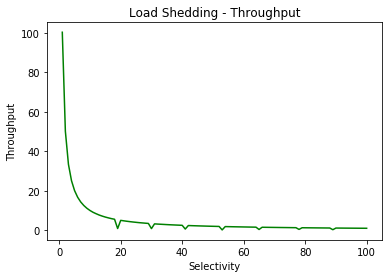

In [102]:
ip = sc.textFile("X_new.csv") \
#     .map(lambda line: line.split(",")).filter(lambda line :len(line)>3).map(lambda x : (x[0]))

# df1 = pd.DataFrame(ip, columns = ["price"])
# df1.to_csv("df1.csv", index=False)
# df1 = sc.textFile("df1.csv").map(lambda line: line.split(",")).collect()
# # print(df1)
# df1 = pd.DataFrame(df1, columns = ["price"])
# print(df1)

X=[0 for a in range(100)]
Y=[0 for a in range(100)]
i=1

while i<=100:
    s=float(i)   
    a1=datetime.now()
    a_operator = ip.filter(lambda x: x%2 == 1)

    a2=datetime.now()
    #microseconds
    micro1=0.000001*(a2-a1).microseconds
    #seconds
    second1=(a2-a1).seconds  
    #overall time passing A
    cost_a=second1+micro1
    tolerance = 1e-4
    if cost_a > tolerance:
        throughA=1/(cost_a*s)
                
        throughA2=throughA
        X[i-1] = s
        Y[i-1]=throughA2/10
        i=i+1
import matplotlib.pyplot as plt
plt.figure()  
plt.plot(X,Y, 'g')   
plt.xlabel('Selectivity')
plt.ylabel("Throughput")
plt.title('Load Shedding - Throughput')
plt.show()

[7]
0.14430609384019133
[73, 40]
0.8352436711470274
[47, 83, 96]
0.4469915615293699
[34, 23, 74, 82]
0.9022429290014019
[68, 67, 41, 61, 81]
0.6888760616805476
[55, 40, 21, 29, 28, 86]
0.8898875786811796
[62, 90, 59, 96, 98, 34, 55]
0.5451589723050102
[61, 72, 19, 77, 76, 35, 52, 6]
0.9743959759214975
[21, 44, 23, 24, 59, 96, 71, 40, 29]
0.9322631776659978
[52, 90, 0, 57, 23, 72, 49, 30, 40, 36]
0.9256205162035127
[82, 15, 95, 62, 35, 30, 59, 29, 94, 41, 95]
0.8061950418675083
[47, 96, 70, 52, 81, 52, 23, 11, 12, 49, 76, 15]
0.9967290618729557
[47, 91, 75, 95, 13, 41, 57, 55, 77, 94, 9, 82, 11]
0.8154214055096385
[67, 73, 90, 61, 21, 86, 65, 29, 27, 95, 77, 71, 49, 55]
0.724805334024432
[96, 8, 47, 52, 97, 77, 74, 24, 36, 62, 73, 52, 70, 66, 31]
0.8111926555069955
[73, 1, 52, 10, 8, 83, 55, 70, 9, 68, 87, 16, 92, 52, 70, 33]
0.9962995794508123
[62, 94, 85, 66, 87, 30, 82, 30, 73, 23, 83, 30, 1, 21, 19, 76, 13]
0.9389257805868287
[23, 15, 41, 52, 95, 61, 57, 36, 0, 9, 33, 52, 62, 12, 8,

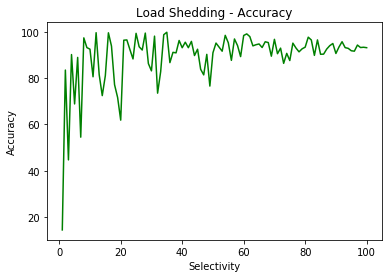

In [101]:
# Generate Uniform Integer Array of n values
from random import sample
n = 100
s = np.random.randint(100, size = (n, ))
# s_1 = sample(pd.Series(s).to_list(),3)
X1=[0 for a in range(100)]
Y1=[0 for a in range(100)]
i = 1
t = 1
u = 1

while i<=100:
    u=float(i) 
    s_1 = sample(pd.Series(s).to_list(),t)
    print(s_1)
    average1 = np.average(s_1)
    accuracy_100 = (average1-average_array)/average_array
    accuracy1 = abs(accuracy_100)
    print(1-accuracy1)
    X1[i-1] = u
    Y1[i-1]=(1-accuracy1) * 100
    t=t+1
    i=i+1
plt.figure()  
plt.plot(X1,Y1, 'g')   
plt.ylabel('Accuracy')
plt.xlabel('Selectivity')
plt.title('Load Shedding - Accuracy')
#plt.axis([0, 1, 0, 1])
plt.show()


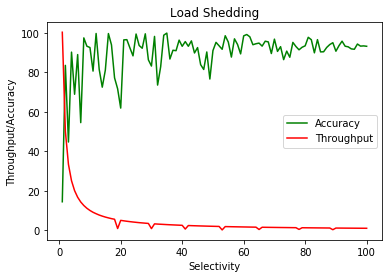

In [108]:
plt.plot(X1,Y1, 'g', label = "Accuracy")   
plt.plot(X,Y, 'r', label = "Throughput")   
plt.xlabel('Selectivity')
plt.ylabel("Throughput/Accuracy")
plt.title('Load Shedding')
plt.legend()
plt.show()


In [13]:
X_new1

,price1,label1,volume1,Sentiment,score,Sentence
0,-2.190097,-2.223646,-0.250351,-1,0.999495,A Quick Garbled Circuits Primer -- vbuterin [v...
1,-2.209513,-2.328425,-0.091589,-1,0.997804,"While You’re Under Quarantine, Check These Sit..."
2,-2.313844,-2.292174,-0.605176,-1,0.991051,This is why we Bitcoin!
3,-2.277748,-2.348534,-0.493557,-1,0.971253,Literally me when dogecoin increases in value
4,-2.333866,-2.520846,-0.357734,-1,0.998433,Bitcoin May Be One of the Last Assets Still Tr...
...,...,...,...,...,...,...
544,0.518070,0.465932,-0.414779,-1,0.882406,🔥Invading Ethereum USDT
545,0.468546,0.429379,-0.315281,1,0.892955,What Holds Real Decentralization Back
546,0.432150,0.475410,-0.639375,-1,0.997909,Russians turn to cash and Bitcoin as coronavir...
547,0.477983,0.449861,-0.676741,1,0.702399,"Tether Mints $720,000,000 This Month | More Th..."


In [14]:
def addRequest(self, r):
    
    HARD_QUOTA = r.shape[0]
    SOFT_QUOTA =0.6 * r.shape[0] 
    STEPS = 1000
    divisor = (HARD_QUOTA - SOFT_QUOTA) / STEPS
 
#     self.received += 1
#     req_modulus = (self.req_modulus + 1) % STEPS
    
    # Are we overloaded?
#     load = self.getLoad()
    r1 = []
    # Become progressively more likely to reject requests
    # once load > soft quota; reject everything once load
    # hits hard limit.
#     threshold = 0.02 * df1.shape[0]
    threshold = divisor
    value = r.values
    for i in range(len(df1)):
        if float(value[i]) < threshold:
      # We're not too loaded
            r1.append((value[i]))
    return pd.Series(r1, index=None)

In [15]:
x1 = addRequest(_,X_new1["price1"])
x2 = addRequest(_,X_new1["label1"])
x3 = addRequest(_,X_new1["volume1"])
x4 = addRequest(_,X_new1["Sentiment"])
x5 = addRequest(_,X_new1["score"])
dataframe = pd.concat([x1,x2,x3,x4,x5], axis=1).fillna(0.5)

C:\Users\vedan\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [16]:
(train_set, val_set, test_set) = df.randomSplit([0.98, 0.01, 0.01], seed = 2000)


## HashingTF + IDF + Logistic Regression


In [17]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [18]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="Sentence", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "label1", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

+-------------------+-------------------+--------------------+---------+------------------+--------------------+--------------------+--------------------+--------------------+-----+
|             price1|             label1|             volume1|Sentiment|             score|            Sentence|               words|                  tf|            features|label|
+-------------------+-------------------+--------------------+---------+------------------+--------------------+--------------------+--------------------+--------------------+-----+
|-2.5978708905433323|-2.4823321185814162|0.040530937390662096|       -1|        0.98433506|"Fed's ""infinite...|["fed's, ""infini...|(65536,[9639,1288...|(65536,[9639,1288...|329.0|
|-2.5054410795262405| -2.613673711717285| 0.07452559523532641|       -1|        0.87768614|     Infinite money!|  [infinite, money!]|(65536,[1285,4083...|(65536,[1285,4083...|188.0|
|-2.4670917892869006|-2.3569688629578414|-0.18347167045309548|       -1|0.9941818000000001

In [ ]:
import sys
def get_prediction(tweet_text):
    try:
#     # filter the tweets whose length is greater than 0
#         tweet_text = tweet_text.filter(lambda x: len(x) > 0)
#     # create a dataframe with column name 'tweet' and each row will contain the tweet
#         rowRdd = tweet_text.map(lambda w: Row(tweet=w))
#     # create a spark dataframe
#         wordsDataFrame = spark.createDataFrame(rowRdd)
    # transform the data using the pipeline and get the predicted sentiment
#         pipelineFit.transform(df).select('Sentence','label1').show()
        pipelineFit.transform(val_set).show()
    except : 
        print('No data')
    
# initialize the streaming context 
ssc = StreamingContext(sc, batchDuration=10)

# Create a DStream that will connect to hostname:port, like localhost:9991
lines = ssc.socketTextStream(sys.argv[0], 9991)

# split the tweet text by a keyword 'TWEET_APP' so that we can identify which set of words is from a single tweet
words = lines.flatMap(lambda line : line.split('REDDIT_APP'))

# get the predicted sentiments for the tweets received
words.foreachRDD(get_prediction)

# Start the computation
ssc.start()             

# Wait for the computation to terminate
ssc.awaitTermination()
ssc.stop()

In [ ]:
# (X_train, X_val), (y_train, y_val) = train_df.randomSplit([0.98, 0.01], seed = 2000), val_df.randomSplit([0.98, 0.01], seed = 2000)

In [ ]:
train_df

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

In [ ]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

In [ ]:
pd.DataFrame(trainingSummary.objectiveHistory).plot()
plt.xlabel("number of iterations")
plt.ylabel("objective function loss")
plt.legend()


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="price1", \
                 labelCol="label1",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(predictions))

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label1')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(val_df)
dt_evaluator = RegressionEvaluator(
    labelCol="label1", predictionCol="price1", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

In [ ]:
dt_model.featureImportances


In [ ]:
# convert it to pandas dataframe
# mention local thing in the presentation.

In [ ]:
pd.DataFrame(predictions).plt(())